# Comparison of 5 regridding algorithms


Those algorithms are available:


In [1]:
method_list = [
    "bilinear",
    "conservative",
    "nearest_s2d",
    "nearest_d2s",
    "patch",
]

- Bilinear and conservative should be the most commonly used methods. They are
  both monotonic (i.e. will not create new maximum/minimum).
- Nearest neighbour methods, either source to destination (s2d) or destination
  to source (d2s), could be useful in special cases. Keep in mind that d2s is
  highly non-monotonic.
- Patch is ESMF's unique method, producing highly smooth results but quite slow.

Detailed explanations are available on
[ESMPy documentation](http://www.earthsystemmodeling.org/esmf_releases/last_built/esmpy_doc/html/api.html#regridding).


## Preparation


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [3]:
ds_in = xe.util.grid_global(20, 15)  # input grid
ds_fine = xe.util.grid_global(4, 4)  # high-resolution target grid
ds_coarse = xe.util.grid_global(30, 20)  # low-resolution target grid

Make a wave field that is widely used in regridding benchmarks.


In [4]:
ds_in["data"] = xe.data.wave_smooth(ds_in["lon"], ds_in["lat"])
ds_in

<xarray.Dataset>
Dimensions:  (y: 12, x: 18, y_b: 13, x_b: 19)
Coordinates:
    lon      (y, x) float64 -170.0 -150.0 -130.0 -110.0 ... 130.0 150.0 170.0
    lat      (y, x) float64 -82.5 -82.5 -82.5 -82.5 ... 82.5 82.5 82.5 82.5
    lon_b    (y_b, x_b) int64 -180 -160 -140 -120 -100 ... 100 120 140 160 180
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 ... 90 90 90 90 90 90
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    data     (y, x) float64 2.016 2.009 1.997 1.987 ... 1.987 1.997 2.009 2.016

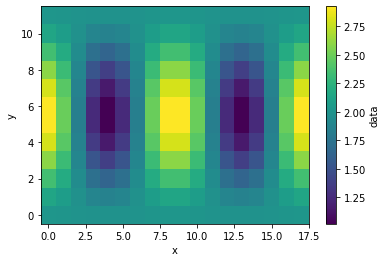

In [5]:
ds_in["data"].plot()

In [6]:
def regrid(ds_in, ds_out, dr_in, method):
    """Convenience function for one-time regridding"""
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True)
    dr_out = regridder(dr_in)
    return dr_out

When dealing with global grids, we need to set `periodic=True`, otherwise data
along the meridian line will be missing.


## Increasing resolution


In [7]:
for method in method_list:
    %time ds_fine[method] = regrid(ds_in, ds_fine, ds_in['data'], method)
    print('')

CPU times: user 414 ms, sys: 13.1 ms, total: 427 ms
Wall time: 444 ms

CPU times: user 82.3 ms, sys: 0 ns, total: 82.3 ms
Wall time: 82.3 ms

CPU times: user 24.2 ms, sys: 0 ns, total: 24.2 ms
Wall time: 24.3 ms

CPU times: user 8.21 ms, sys: 0 ns, total: 8.21 ms
Wall time: 8.23 ms

CPU times: user 476 ms, sys: 2.7 ms, total: 478 ms
Wall time: 478 ms



Nearest neighbour algorithms are very fast while the patch method is quite slow.


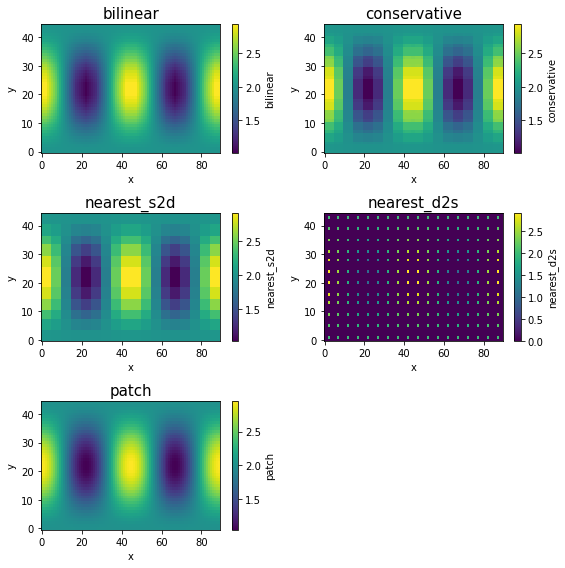

In [8]:
fig, axes = plt.subplots(3, 2, figsize=[8, 8])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_fine[method].plot.pcolormesh(ax=ax)
    ax.set_title(method, fontsize=15)
axes[-1, -1].set_visible(False)
plt.tight_layout()

When regridding from low-resolution to high-resolution, `bilinear` and `patch`
will produce smooth results, while `conservative` and `nearest_s2d` will
preserve the original coarse grid structure (although the data is now defined on
a finer grid.).

`nearest_d2s` is quite different from others: One source point can be mapped to
**only one destination point**. Because we have far less source points (on a
low-resolution grid) than destination points (on a high-resolution grid), most
destination points cannot receive any data so they just have zero values. Only
the destination points that are closest to source points can receive data.


## Decreasing resolution


In [9]:
for method in method_list:
    ds_coarse[method] = regrid(ds_in, ds_coarse, ds_in["data"], method)

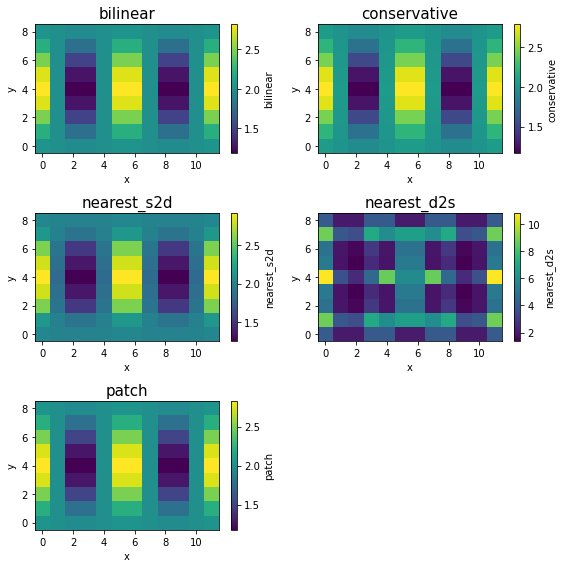

In [10]:
fig, axes = plt.subplots(3, 2, figsize=[8, 8])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_coarse[method].plot.pcolormesh(ax=ax)
    ax.set_title(method, fontsize=15)
axes[-1, -1].set_visible(False)
plt.tight_layout()

When regridding from high-resolution to low-resolution, all methods except
`nearest_d2s` produce similar results here. But that's largely because the input
data is smooth. For real-world data, it is generally recommended to use
`conservative` for upscaling, because it takes average over small source grid
boxes, while `bilinear` and `nearest_s2d` effectively throw away most of source
grid boxes.

`nearest_d2s` is again different: **Every** source point **has to be** mapped to
a destination point. Because we have far more source points (on a
high-resolution grid) than destination points (on a low-resolution grid), a
single destination point will receive data from multiple source points, which
can accumulate to a large value (notice the colorbar range).
